# **Here we begin, first by choosing a company**
I chose Infosys as its graph as many ups and downs and my regression works good on it.

In [1]:
#We are importing all necessary libraries to implement our model
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from sklearn import preprocessing #For data split into test and train
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


# Step 1: Data Extraction
def extract_data(symbol, start_date, end_date, interval):
    data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
    return data

# Choosing Infosys (INFY) with a time frame of the past year and daily interval
start_date = "2023-01-01"
end_date = "2024-01-01"
symbol = "INFY.NS"
interval = "1d"
data = extract_data(symbol, start_date, end_date, interval)
print("Data Shape:", data.shape)
print(data.head())


ModuleNotFoundError: No module named 'yfinance'

#**2. Calculation of Technical Indicators**
# In this section, various technical indicators are calculated based on the extracted financial data of Infosys Limited. These indicators offer insights into the stock's price movements and potential trends. The following technical indicators are computed:

4.1. Simple Moving Average (SMA)
The Simple Moving Average (SMA) is calculated with a window of 20 days. It represents the average closing price of the stock over a specified period, smoothing out short-term fluctuations and highlighting longer-term trends.

4.2. Exponential Moving Average (EMA)
The Exponential Moving Average (EMA) is computed with a window of 50 days. EMA gives more weight to recent prices, making it more responsive to price changes compared to SMA.

4.3. Moving Average Convergence Divergence (MACD)
MACD is derived from two EMAs: a short-term EMA (12 days) and a long-term EMA (26 days). It indicates the relationship between these EMAs and helps identify potential trend reversals or momentum shifts.

4.4. Bollinger Bands
Bollinger Bands consist of a middle band (SMA) and two outer bands that are standard deviations away from the middle band. They help identify potential overbought or oversold conditions and volatility changes.

4.5. Relative Strength Index (RSI)
RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions. It is calculated based on the average gains and losses over a specified period (usually 14 days).

I have chosen these indicators as they were simple, very widely used across the internet and they fit well with the 5-day window I am using for buy, sell and hold.

In [ ]:
# Step 2: Calculate Technical Indicators
def calculate_sma(data, window=20):
    return data['Close'].rolling(window=window, min_periods=1).mean()

def calculate_ema(data, window=50):
    return data['Close'].ewm(span=window, adjust=False).mean()

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = calculate_ema(data, short_window)
    long_ema = calculate_ema(data, long_window)
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    sma = data['Close'].rolling(window=window, min_periods=1).mean()
    rolling_std = data['Close'].rolling(window=window, min_periods=1).std()

    # Apply forward fill and backward fill to handle NaN values
    sma = sma.fillna(method='ffill').fillna(method='bfill')
    rolling_std = rolling_std.fillna(method='ffill').fillna(method='bfill')

    upper_band = sma + (rolling_std * num_std_dev)
    lower_band = sma - (rolling_std * num_std_dev)

    return upper_band, lower_band


def calculate_rsi(data, window=14):
    delta = data['Close'].diff()

    # Apply forward fill and backward fill before rolling calculations
    delta = delta.fillna(method='ffill').fillna(method='bfill')

    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()

    # Apply forward fill and backward fill to handle NaN values after rolling calculations
    gain = gain.fillna(method='ffill').fillna(method='bfill')
    loss = loss.fillna(method='ffill').fillna(method='bfill')

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi





In [ ]:
# Step 3: Create New Features
def create_features(data):
    data['SMA'] = calculate_sma(data)
    data['EMA'] = calculate_ema(data)
    data['SMA_50'] = calculate_sma(data, 50)
    data['EMA_12'] = calculate_ema(data, 12)
    data['MACD'], data['MACD_Signal'] = calculate_macd(data)
    data['Upper_Band'], data['Lower_Band'] = calculate_bollinger_bands(data, 20, 2)
    data['RSI'] = calculate_rsi(data)

    return data


#***4. Construction of Target Variable***
#The target variable is constructed in this step to facilitate the classification of buy, sell, or hold signals based on historical stock price data. This target variable will be used in subsequent steps for training and evaluating predictive models. The following procedure is employed to construct the target variable:

Methodology
Window Specification: A window of 5 days is chosen to compute the average closing price for the next five days.

Signal Determination:

For each day in the dataset, the closing price of the current day (today_close) is compared with the average closing price of the next five days (avg_next_five_days_close).

* If the average closing price of the next five days is higher than the current
day's closing price, a 'Buy' signal is generated.
* If the average closing price of the next five days is lower than the current day's closing price, a 'Sell' signal is generated.
* If there is no significant difference between the current day's closing price and the average closing price of the next five days, a 'Hold' signal is generated.

In [ ]:
# Step 4: Target Variable Construction
def construct_target_variable(data, window=5):
    signals = []
    for i in range(len(data) - window):
        today_close = data['Close'].iloc[i]

        # Calculate the average of the next five days' closing prices
        if i + window < len(data):
            avg_next_five_days_close = data['Close'].iloc[i + 1:i + window + 1].mean()
        else:
            avg_next_five_days_close = data['Close'].iloc[i + 1]  # Use next day's price if less than five days remaining

        if avg_next_five_days_close > today_close:
            signals.append('Buy')
        elif avg_next_five_days_close < today_close:
            signals.append('Sell')
        else:
            signals.append('Hold')

    # Last window's signal is 'Hold' as there are not enough next five days' prices for comparison
    for _ in range(window):
        signals.append('Hold')

    data['Signal'] = signals

    return data



#***Visualization of Data with Signals***
In this section, a function named plot_data_with_signals is defined to visualize the closing price of Infosys Limited's stock along with the corresponding signals ('Buy,' 'Sell,' or 'Hold') generated by the constructed target variable.

* Function: plot_data_with_signals
This function plots the closing price of the stock over time and highlights the data points where signals are generated. The signals are represented by colored markers: green for 'Buy,' red for 'Sell,' and blue for 'Hold.'

In [ ]:
import matplotlib.pyplot as plt

def plot_data_with_signals(data, signal, interval=5):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data.index, data['Close'], label='Close Price', color='black')

    for i in range(0, len(data), interval):
        if data[signal][i] == 'Buy':
            ax.scatter(data.index[i], data['Close'].iloc[i], color='green', marker='^', s=100)
        elif data[signal][i] == 'Sell':
            ax.scatter(data.index[i], data['Close'].iloc[i], color='red', marker='v', s=100)
        else:
            ax.scatter(data.index[i], data['Close'].iloc[i], color='blue', marker='o', s=100)

    # Static legend
    ax.scatter([], [], color='green', marker='^', label='Buy')
    ax.scatter([], [], color='red', marker='v', label='Sell')
    ax.scatter([], [], color='blue', marker='o', label='Hold')
    ax.legend(loc='lower right')

    ax.set_title('Close Price with Buy/Sell/Hold Signals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#***Logistic Regression Class Implementation Overview***
1. Initialization
The LogisticRegression class initializes the logistic regression object with parameters such as the learning rate (alpha) and the number of iterations (n_iterations). These parameters control the training process and optimization of the model.

2. Sigmoid Function
The _sigmoid_function method computes the sigmoid transformation of the input data. The sigmoid function maps any real-valued number to a value between 0 and 1. It's utilized in logistic regression to transform the output of the linear equation into probabilities.

3. Cost Function
The _cost_function method calculates the logistic loss, also known as the cross-entropy loss. This function measures the difference between the predicted probabilities and the actual labels. It quantifies how well the model is performing during training.

4. Gradient Descent
The _gradient_descent method updates the model parameters (theta) using gradient descent. Gradient descent is an optimization algorithm that iteratively adjusts the parameters to minimize the cost function. It computes the gradient of the cost function with respect to each parameter and moves in the direction of the steepest descent.

5. Fitting the Model
The fit method trains the logistic regression model on the provided training data. It iterates through unique labels and performs binary classification using the One-vs-All technique for multiclass classification tasks. During training, it optimizes the model parameters using gradient descent to minimize the cost function.

6. Prediction
The predict method predicts the labels for the given input features using the trained model. It applies the learned parameters to the input data and computes the predicted labels based on the maximum probability among different classes.

7. Model Evaluation
The score method evaluates the performance of the model by comparing the predicted labels with the actual labels. It calculates the accuracy of the model, which is the proportion of correctly predicted labels to the total number of samples.

In [ ]:
#We are importing all necessary libraries to implement our model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


class LogisticRegression(object):

    def __init__(Logreg, alpha=0.01, n_iteration=100):  #This function intializes the alpha value and iteration
        Logreg.alpha = alpha                            #value in the object
        Logreg.n_iter = n_iteration

    def _sigmoid_function(Logreg, x): #This function is resonsible for calculating the sigmoid value with given parameter
        value = 1 / (1 + np.exp(-x))
        return value
    def _cost_function(Logreg,h,theta, y): # The fuctions calculates the cost value
        m = len(y)
        cost = (1 / m) * (np.sum(-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))))
        return cost

    def _gradient_descent(Logreg,X,h,theta,y,m): # This function calculates the theta value by gradient descent
        gradient_value = np.dot(X.T, (h - y)) / m
        theta -= Logreg.alpha * gradient_value
        return theta

    def fit(Logreg, X, y): #This function primarily calculates the optimal theta value using which we predict the future data
        print("Fitting the given dataset..")
        Logreg.theta = []
        Logreg.cost = []
        X = np.insert(X, 0, 1, axis=1)
        m = len(y)
        for i in np.unique(y):
            #print('Descending the gradient for label type ' + str(i) + 'vs Rest')
            y_onevsall = np.where(y == i, 1, 0)
            theta = np.zeros(X.shape[1])
            cost = []
            for _ in range(Logreg.n_iter):
                z = X.dot(theta)
                h = Logreg._sigmoid_function(z)
                theta = Logreg._gradient_descent(X,h,theta,y_onevsall,m)
                cost.append(Logreg._cost_function(h,theta,y_onevsall))
            Logreg.theta.append((theta, i))
            Logreg.cost.append((cost,i))
        return Logreg

    def predict(Logreg, X): # this function calls the max predict function to classify the individul feauter
        X = np.insert(X, 0, 1, axis=1)
        X_predicted = [max((Logreg._sigmoid_function(i.dot(theta)), c) for theta, c in Logreg.theta)[1] for i in X ]

        return X_predicted

    def score(Logreg,X, y): #This function compares the predictd label with the actual label to find the model performance
        score = sum(Logreg.predict(X) == y) / len(y)
        return score

    def _plot_cost(Logreg,costh): # This function plot the Cost function value
        for cost,c in costh   :
                plt.plot(range(len(cost)),cost,'r')
                plt.title("Convergence Graph of Cost Function of type-" + str(c) +" vs All")
                plt.xlabel("Number of Iterations")
                plt.ylabel("Cost")
                plt.show()




In [ ]:
# Plot data with signals
def generate_signals(model, X):
  X_predicted = model.predict(X)
  return X_predicted

[*********************100%%**********************]  1 of 1 completed


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-01-02  1514.000000  1526.500000  1504.050049  1524.000000  1484.572144   
2023-01-03  1519.849976  1532.650024  1515.099976  1522.550049  1483.159668   
2023-01-04  1521.000000  1521.000000  1491.099976  1494.800049  1456.127563   
2023-01-05  1505.900024  1505.900024  1469.250000  1475.199951  1437.034546   
2023-01-06  1470.000000  1475.000000  1446.500000  1448.500000  1411.025391   

             Volume          SMA          EMA       SMA_50       EMA_12  \
Date                                                                      
2023-01-02  3801140  1524.000000  1524.000000  1524.000000  1524.000000   
2023-01-03  4551130  1523.275024  1523.943139  1523.275024  1523.776931   
2023-01-04  7059590  1513.783366  1522.800273  1513.783366  1519.318949   
2023-01-05  9868404  1504.137512  1520.933594  1504.137512  1512.531411

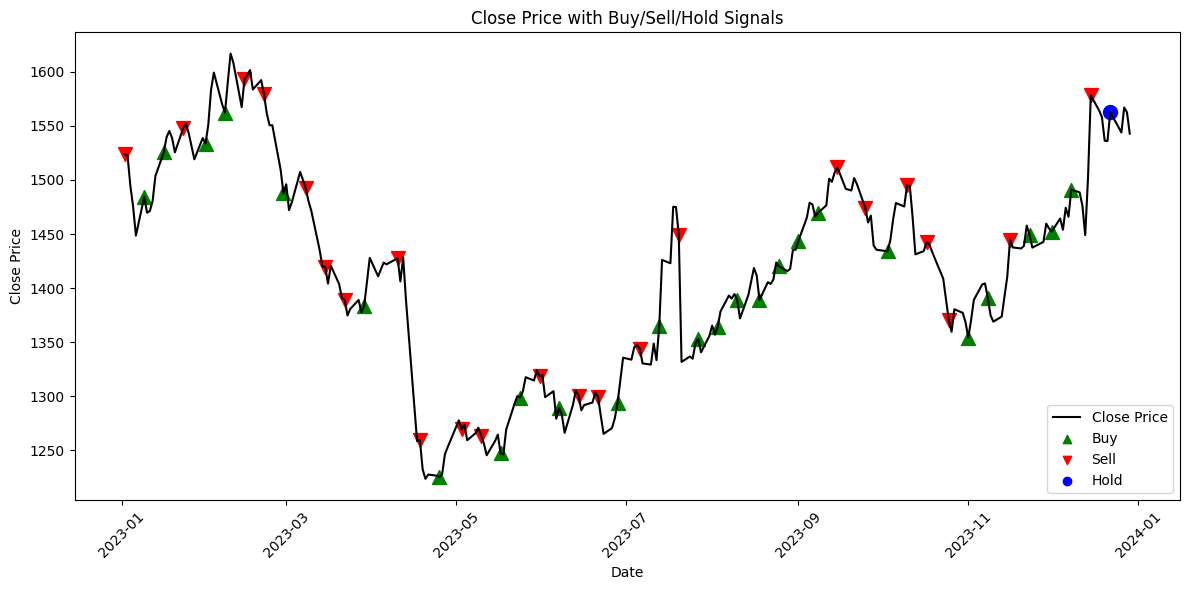

[[ 0.99898491  0.99878976  1.03396727 ...  0.43038942  1.86659807
  -2.65013848]
 [ 1.05907998  1.06077343  1.14893358 ...  0.42262506  1.85896479
  -2.65013848]
 [ 1.07089384  0.94335743  0.89923135 ...  0.65149216  1.43408552
  -2.65013848]
 ...
 [ 1.30716605  1.43720909  1.44961693 ...  1.18761882  0.70004346
   0.72190713]
 [ 1.56346952  1.42662606  1.56406378 ...  1.25423701  0.74305156
   0.76451011]
 [ 1.27686207  1.33087931  1.40799989 ...  1.27500918  0.81502225
   0.39691143]]
Fitting the given dataset..
Accuracy is:  0.6172839506172839
Fitting the given dataset..
Accuracy is:  0.6296296296296297
Fitting the given dataset..
Accuracy is:  0.5679012345679012
Fitting the given dataset..
Accuracy is:  0.5308641975308642
Fitting the given dataset..
Accuracy is:  0.6172839506172839
Fitting the given dataset..
Accuracy is:  0.6790123456790124
Fitting the given dataset..
Accuracy is:  0.6049382716049383
Fitting the given dataset..
Accuracy is:  0.5555555555555556
Fitting the given da

In [ ]:
# Main Function
def main():
    # Step 1: Data Extraction
    data = extract_data(symbol, start_date, end_date, interval)

    # Step 3: Feature Engineering
    features = create_features(data)

    # Step 4: Target Variable Construction
    data = construct_target_variable(data)

    return data  # Return the modified data DataFrame

if __name__ == "__main__":
    modified_data = main()  # Assign the returned modified data DataFrame to a variable
    print(modified_data.head())  # Print the modified data DataFrame
    plot_data_with_signals(modified_data, "Signal", interval=5)

    y_data = modified_data['Signal'].values  #segregating the label vlue from the feature value.
    X = modified_data.drop(['Signal'],axis=1).values

    scaler = StandardScaler()
    X= scaler.fit_transform(X)
    print(X)

    # Train the logistic regression model multiple times and select the best model
    best_model = None
    best_accuracy = 0
    for _ in range(15):
        X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.33)
        logi = LogisticRegression(n_iteration=30000).fit(X_train, y_train)
        accuracy = logi.score(X_test, y_test)
        print("Accuracy is: ",accuracy)
        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_model = logi

    print("The best accuracy of the model is ", best_accuracy)

        # Generate signals using the best model
    signals = generate_signals(best_model, X)

        # Calculate F1 score
    f1 = f1_score(y_test, best_model.predict(X_test), average='weighted')
    print("F1 Score:", f1)


# **Here we plot the results!**

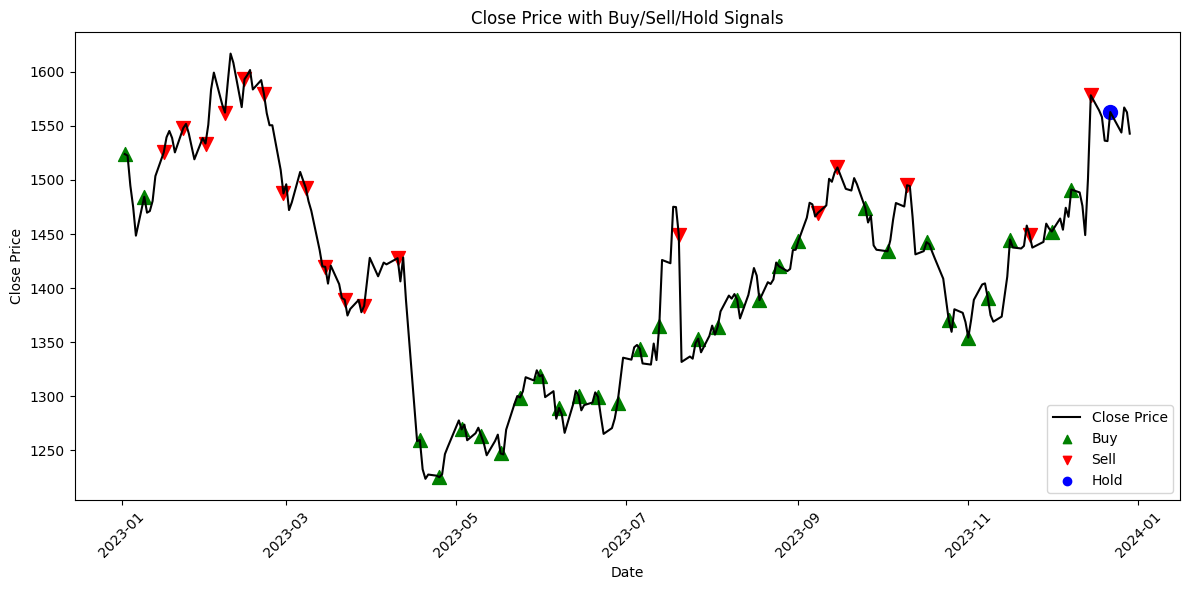

In [ ]:
signals = generate_signals(best_model, X)
modified_data['Signals_Predicted'] = signals

plot_data_with_signals(modified_data, 'Signals_Predicted', interval=5)


In [ ]:
print(modified_data[:])

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-01-02  1514.000000  1526.500000  1504.050049  1524.000000  1484.572144   
2023-01-03  1519.849976  1532.650024  1515.099976  1522.550049  1483.159668   
2023-01-04  1521.000000  1521.000000  1491.099976  1494.800049  1456.127563   
2023-01-05  1505.900024  1505.900024  1469.250000  1475.199951  1437.034546   
2023-01-06  1470.000000  1475.000000  1446.500000  1448.500000  1411.025391   
...                 ...          ...          ...          ...          ...   
2023-12-22  1534.949951  1566.000000  1523.000000  1562.900024  1562.900024   
2023-12-26  1535.000000  1548.000000  1523.000000  1543.949951  1543.949951   
2023-12-27  1544.000000  1570.000000  1544.000000  1567.099976  1567.099976   
2023-12-28  1568.949951  1568.949951  1555.000000  1562.650024  1562.650024   
2023-12-29  1541.050049  1559.449951  1540.000000  1